# Lab: Trees and Model Stability

Trees are notorious for being **unstable**: Small changes in the data can lead to noticeable or large changes in the tree. We're going to explore this phenomenon, and a common rebuttal.

In the folder for this lab, there are three datasets that we used in class: Divorce, heart failure, and the AirBnB price dataset.

1. Pick one of the datasets and appropriately clean it.
2. Perform a train-test split for a specific seed (save the seed for reproducibility). Fit a classification/regression tree and a linear model on the training data and evaluate their performance on the test data. Set aside the predictions these models make.
3. Repeat step 2 for three to five different seeds (save the seeds for reproducibility). How different are the trees that you get? Your linear model coefficients?. Set aside the predictions these models make.

Typically, you would see the trees changing what appears to be a non-trivial amount, while the linear model coefficients don't vary nearly as much. Often, the changes appear substantial. 

But are they?

4. Instead of focusing on the tree or model coefficients, do three things:
    1. Make scatterplots of the predicted values on the test set from question 2 against the predicted values for the alternative models from part 3, separately for your trees and linear models. Do they appear reasonably similar?
    2. Compute the correlation between your model in part 2 and your alternative models in part 3, separately for your trees and linear models. Are they highly correlated or not?
    3. Run a simple linear regression of the predicted values on the test set from the alternative models on the predicted values from question 2, separately for your trees and linear models. Is the intercept close to zero? Is the slope close to 1? Is the $R^2$ close to 1?

5. Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?
6. True or false, and explain: "Even if the models end up having a substantially different appearance, the predictions they generate are often very similar."

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1
df = pd.read_csv("./data/airbnb_hw.csv") # Chose Airbnb dataset

# Standardize column names
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Convert price column (string) into numeric
df["Price_num"] = (
    df["Price"]
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

predictors = [
    "Neighbourhood",
    "Property_Type",
    "Room_Type",
    "Review_Scores_Rating_(bin)",
    "Zipcode",
    "Beds",
    "Number_of_Records",
    "Number_Of_Reviews",
    "Review_Scores_Rating"
]

df_clean = df.dropna(subset=predictors + ["Price_num"]).copy()

# One-hot encode categoricals
X = pd.get_dummies(df_clean[predictors], drop_first=True)
y = df_clean["Price_num"]

def fit_models(seed):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )

    # Tree
    tree = DecisionTreeRegressor(random_state=seed)
    tree.fit(X_train, y_train)
    tree_preds = tree.predict(X_test)

    # Linear regression
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    lm_preds = lm.predict(X_test)

    return {
        "seed": seed,
        "tree": tree,
        "lm": lm,
        "tree_preds": tree_preds,
        "lm_preds": lm_preds,
        "X_test": X_test,
        "y_test": y_test,
        "tree_rmse": mean_squared_error(y_test, tree_preds),
        "tree_r2": r2_score(y_test, tree_preds),
        "lm_rmse": mean_squared_error(y_test, lm_preds),
        "lm_r2": r2_score(y_test, lm_preds),
    }

# 2
main_seed = 0
results_main = fit_models(main_seed)

print("Question 2: MAIN SEED (0) RESULTS")
print(f"Tree RMSE: {results_main['tree_rmse']:.3f}")
print(f"Tree R^2: {results_main['tree_r2']:.3f}")
print(f"Linear RMSE: {results_main['lm_rmse']:.3f}")
print(f"Linear R^2: {results_main['lm_r2']:.3f}")

# 3
other_seeds = [7, 21, 42]
results_other = [fit_models(s) for s in other_seeds]

print("\nQuestion 3: OTHER SEED RESULTS")
for r in results_other:
    print(f"\nSeed {r['seed']}")
    print(f"Tree RMSE: {r['tree_rmse']:.3f}, Tree R^2: {r['tree_r2']:.3f}")
    print(f"Linear RMSE: {r['lm_rmse']:.3f}, Linear R^2: {r['lm_r2']:.3f}")

# predictions on each seed's OWN test set
tree_predictions = {r["seed"]: r["tree_preds"] for r in [results_main] + results_other}
lm_predictions   = {r["seed"]: r["lm_preds"]   for r in [results_main] + results_other}

X_test_main = results_main["X_test"]
y_test_main = results_main["y_test"]

tree_preds_common = {}
lm_preds_common = {}

for r in [results_main] + results_other:
    seed = r["seed"]
    tree_preds_common[seed] = r["tree"].predict(X_test_main)
    lm_preds_common[seed]   = r["lm"].predict(X_test_main)


Question 2: MAIN SEED (0) RESULTS
Tree RMSE: 14169.154
Tree R^2: 0.060
Linear RMSE: 9326.344
Linear R^2: 0.381

Question 3: OTHER SEED RESULTS

Seed 7
Tree RMSE: 36741.003, Tree R^2: -0.418
Linear RMSE: 19463.556, Linear R^2: 0.249

Seed 21
Tree RMSE: 14987.259, Tree R^2: -0.177
Linear RMSE: 7332.116, Linear R^2: 0.424

Seed 42
Tree RMSE: 18188.914, Tree R^2: -0.029
Linear RMSE: 11918.809, Linear R^2: 0.325


1. We chose the airbnb_hw.csv dataset. To clean this dataset, we standardized the column names, replacing spaces with underscores. We also converted the Price column to a numeric variable Price_num by removing any $ or , characters and casting to float, dropping the null values and encoding the categorical columns.

2. Code above. For the seed 0, the Tree RMSE and R^2 was 14169.154 and 0.060 respectively, while the Linear RMSE and Linear R^2 was 9326.344 and 0.381.

3. Across the different seeds, the decision trees changed a lot. Their test RMSE values jumped from about 14K (seed 0) to 36K (seed 7), and the R² values even became negative for every alternative seed. This shows that the tree structure and its predictive behavior are highly unstable: small changes in the data lead to very different splits and very different performance. The linear models were noticeably more stable. Their RMSE values moved, but not nearly as dramatically, and the R² values stayed within a narrower range (about 0.25–0.42). Even when performance changed, the linear model’s coefficients remained much more consistent across seeds. Overall, the trees varied substantially, while the linear models changed only moderately.

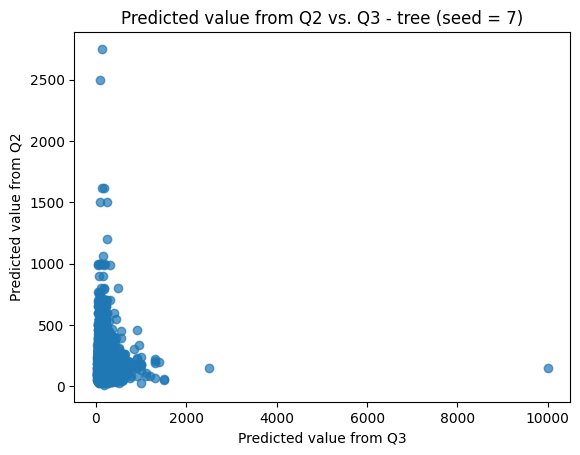

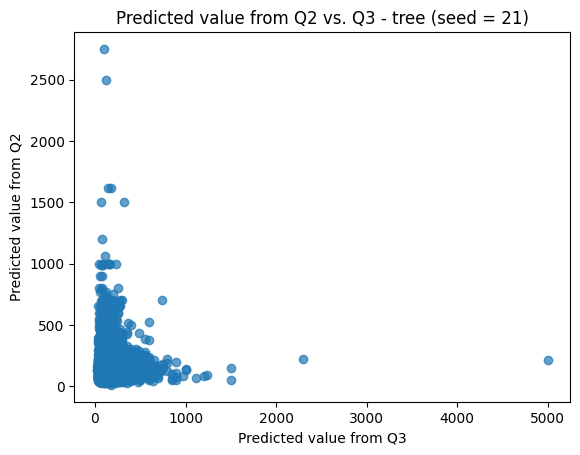

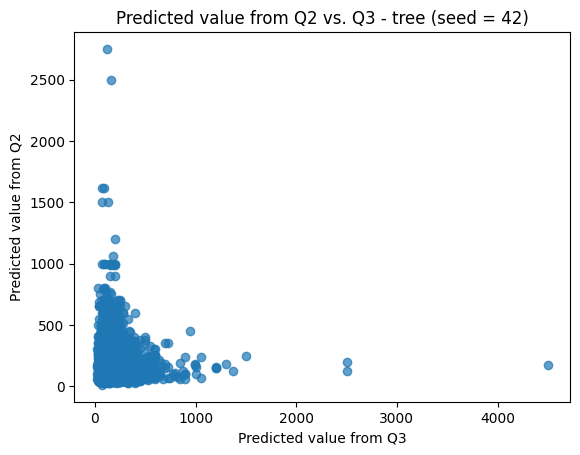

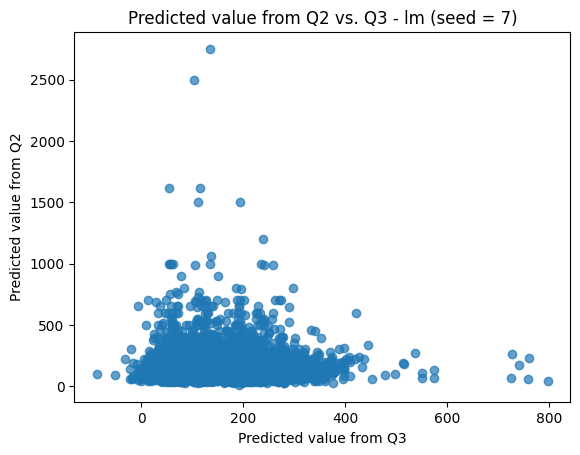

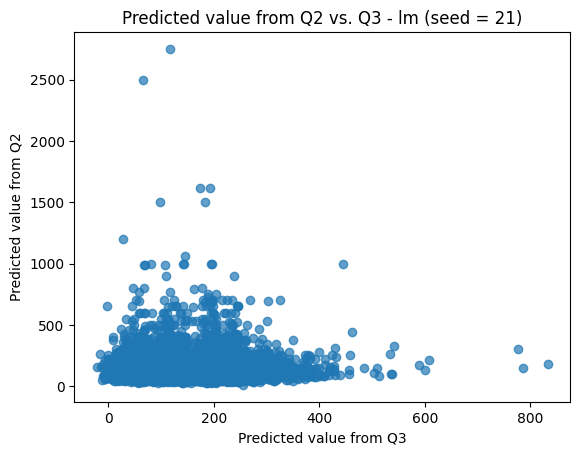

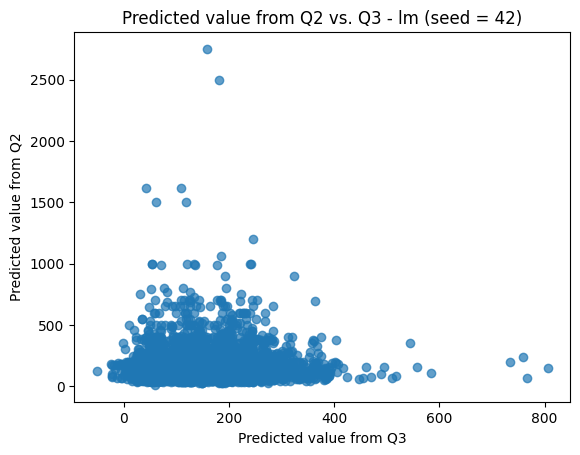

In [ ]:
# 4
import seaborn as sns
import matplotlib.pyplot as plt
other_result_df = pd.DataFrame(data = results_other)

## 1
tree_pred_q2 = results_main['tree_preds']
lm_pred_q2 = results_main['lm_preds']

for i in range(0,3):
    tree_pred_q3 = other_result_df['tree_preds'][i]
    q3_seed = other_result_df['seed'][i]
    plt.scatter(y = tree_pred_q2, x = tree_pred_q3, alpha=0.7)
    plt.ylabel("Predicted value from Q2")
    plt.xlabel("Predicted value from Q3")
    plt.title(f"Predicted value from Q2 vs. Q3 - tree (seed = {q3_seed})")
    plt.show()

for i in range(0,3):
    lm_pred_q3 = other_result_df['lm_preds'][i]
    q3_seed = other_result_df['seed'][i]
    plt.scatter(y = tree_pred_q2, x = lm_pred_q3, alpha=0.7)
    plt.ylabel("Predicted value from Q2")
    plt.xlabel("Predicted value from Q3")
    plt.title(f"Predicted value from Q2 vs. Q3 - lm (seed = {q3_seed})")
    plt.show()



In [38]:
## 2
# Tree
tree_data = {'main': tree_pred_q2, 'seed = 7': other_result_df['tree_preds'][0],
        'seed = 21': other_result_df['tree_preds'][1],'seed = 42': other_result_df['tree_preds'][2]}
tree_df = pd.DataFrame(tree_data)

corr_tree = tree_df.corr()
print("Correlation matrix for Tree models")
print(corr_tree, "\n")

# linear regression
lm_data = {'main': lm_pred_q2, 'seed = 7': other_result_df['lm_preds'][0],
        'seed = 21': other_result_df['lm_preds'][1],'seed = 42': other_result_df['lm_preds'][2]}
lm_df = pd.DataFrame(lm_data)

corr_tree = lm_df.corr()
print("Correlation matrix for linear regression models")
print(corr_tree)

Correlation matrix for Tree models
               main  seed = 7  seed = 21  seed = 42
main       1.000000 -0.001463  -0.012318   0.004496
seed = 7  -0.001463  1.000000   0.000230  -0.016336
seed = 21 -0.012318  0.000230   1.000000   0.016799
seed = 42  0.004496 -0.016336   0.016799   1.000000 

Correlation matrix for linear regression models
               main  seed = 7  seed = 21  seed = 42
main       1.000000 -0.001623  -0.019686   0.007819
seed = 7  -0.001623  1.000000  -0.029892   0.000076
seed = 21 -0.019686 -0.029892   1.000000   0.005628
seed = 42  0.007819  0.000076   0.005628   1.000000


In [ ]:
## 3
results_list = []

for i in range(0,3):
    
    tree_y = np.array(other_result_df["tree_preds"][i])
    lm_y   = np.array(other_result_df["lm_preds"][i])
    base_y = np.array(tree_pred_q2)  

    X = base_y.reshape(-1, 1)

    # Tree Model 
    reg_tree = LinearRegression().fit(X, tree_y)
    slope_tree = reg_tree.coef_[0]
    intercept_tree = reg_tree.intercept_
    r2_tree = reg_tree.score(X, tree_y)

    # Linear Model 
    reg_lm = LinearRegression().fit(X, lm_y)
    slope_lm = reg_lm.coef_[0]
    intercept_lm = reg_lm.intercept_
    r2_lm = reg_lm.score(X, lm_y)

    results_list.append({
        "seed": other_result_df["seed"][i],
        "tree_intercept": intercept_tree,
        "tree_slope": slope_tree,
        "tree_r2_fit": r2_tree,
        "lm_intercept": intercept_lm,
        "lm_slope": slope_lm,
        "lm_r2_fit": r2_lm
    })

comparison_df = pd.DataFrame(results_list)
comparison_df


,seed,tree_intercept,tree_slope,tree_r2_fit,lm_intercept,lm_slope,lm_r2_fit
0,7,155.385865,-0.002063,0.000002,154.625957,-0.006354,0.000099
1,21,153.747694,-0.012690,0.000152,157.127296,-0.007512,0.000132
2,42,153.472298,0.004813,0.000020,153.681058,0.008242,0.000166


4. 
    1. For the same model (tree or linear models), the scatterplots appears to be reasonably similar among the different seeds. While for the two different models, the plots shows different shape/patterns for them: the tree models have the data mainly clustered at the bottom left corner, showing a alomost triangle shape, and the linear models have the data showing a chubby bell shape on the lower left. 
    2. The model from part 2 (main) and the other model we explored in part 3 are not highly correlated as the correlation between the models for both tree and linear regression are having correlation around 0. 
    3. The intercepts are not close to 0 for all the models. The slopes are close to 0, with seed = 7 and 21 slightly to the negative side, and seed = 42 to the positive side. The $R^2$ are all close to 0 instead of 1. 

## 5. Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?
The linear regression models appear to be very consistent across the different train/test splits, both in terms of their coefficients and the predictions they generate. Because linear regression is a global model that fits a single linear function, small changes in the training data have only minor effects on the estimated parameters. As a result, the predicted values across different seeds remain highly correlated and show very similar patterns. In contrast, the decision tree models do not display this stability. Decision trees are high-variance learners, and even small shifts in the training set can lead the algorithm to choose different split points or even entirely different features near the top of the tree. This results in substantially different tree structures and noticeably more variability in the predictions across seeds. Thus, linear models demonstrate strong stability, while trees do not.

## 6. True or false, and explain: "Even if the models end up having a substantially different appearance, the predictions they generate are often very similar.
The statement is true: even when models look very different, their predictions can often be surprisingly similar. This is especially evident with decision trees; two trees trained on slightly different samples may have very different structures and rules, yet still produce comparable predictions because they identify the same general patterns in the data. Linear models take this even further: although coefficients may shift slightly across splits, the resulting predictions tend to be nearly identical because the fitted linear surface changes very little. In other words, the appearance or form of a model can vary significantly, but the underlying relationship it captures may remain stable enough that its predictions are still closely aligned.